# Exploration of population size for derangement test power

We ran the derangement test for 100 different seeds and varied the population size to find the "breaking point" for various PRNGs.

In [1]:
library(dplyr)
library(ggplot2)
library(reshape2)
library(stringr)
options(warn = (-1), message = (-1))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
combinations <- expand.grid(c("MT", "SD", "SHA256"),
                            c("pi", "fykd"))

rawdatafiles <- list.files("../rawdata/")

res <- lapply(1:nrow(combinations), function(index){
  filename <- paste0(combinations[index, 1],
                     "_derangements_", combinations[index, 2], "_findn.csv")
  if(!(filename %in% rawdatafiles)){ return()}
  
  tmp <- read.csv(paste0("../rawdata/", filename), header = TRUE)
  return(tmp)
})
res <- do.call(rbind, res)

In [3]:
head(res)

prng,algorithm,seed,n,decision_upper,LR_upper,steps_upper,decision_lower,LR_lower,steps_lower
MT,permute_indices,739828299,500,None,1.429876e-12,1000000,None,3.678261e-14,1000000
MT,permute_indices,739828299,1000,None,1.327523e-10,1000000,None,3.887368e-16,1000000
MT,permute_indices,739828299,1500,None,2.547847e-08,1000000,None,1.981345e-18,1000000
MT,permute_indices,739828299,2000,None,3.597479e-09,1000000,None,1.414805e-17,1000000
MT,permute_indices,739828299,2500,None,7.450186e-15,1000000,None,7.216693e-12,1000000
MT,permute_indices,739828299,3000,None,1.857022e-15,1000000,None,2.912163e-11,1000000


In [4]:
tmp <- melt(res, id.vars = c("prng", "algorithm", "seed", "n"))
splitCols <- str_split_fixed(tmp$variable, "_", 2)
colnames(splitCols) <- c("var", "alternative")
tmp <- cbind(tmp, splitCols)
res <- dcast(tmp, prng+algorithm+seed+alternative+n ~ var, value.var = "value")
str(res)

'data.frame':	7200 obs. of  8 variables:
 $ prng       : Factor w/ 3 levels "MT","SD","SHA256": 1 1 1 1 1 1 1 1 1 1 ...
 $ algorithm  : Factor w/ 2 levels "permute_indices",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ seed       : num  1.49e+08 1.49e+08 1.49e+08 1.49e+08 1.49e+08 ...
 $ alternative: Factor w/ 2 levels "lower","upper": 1 1 1 1 1 1 2 2 2 2 ...
 $ n          : int  500 1000 1500 2000 2500 3000 500 1000 1500 2000 ...
 $ decision   : chr  "None" "None" "None" "None" ...
 $ LR         : chr  "4.34360654669e-16" "5.75573628076e-15" "1.89737362406e-15" "2.79845923449e-13" ...
 $ steps      : chr  "1000000" "1000000" "1000000" "1000000" ...


In [7]:
print("Rejection rates, by alternative")
res %>% group_by(prng, algorithm, alternative) %>% summarise("Rejection rate" = mean(decision == "1"))

[1] "Rejection rates, by alternative"


prng,algorithm,alternative,Rejection rate
MT,permute_indices,lower,0.01666667
MT,permute_indices,upper,0.02166667
MT,fykd,lower,0.02666667
MT,fykd,upper,0.02166667
SD,permute_indices,lower,0.02666667
SD,permute_indices,upper,0.01833333
SD,fykd,lower,0.05166667
SD,fykd,upper,0.06333333
SHA256,permute_indices,lower,0.01833333
SHA256,permute_indices,upper,0.02833333


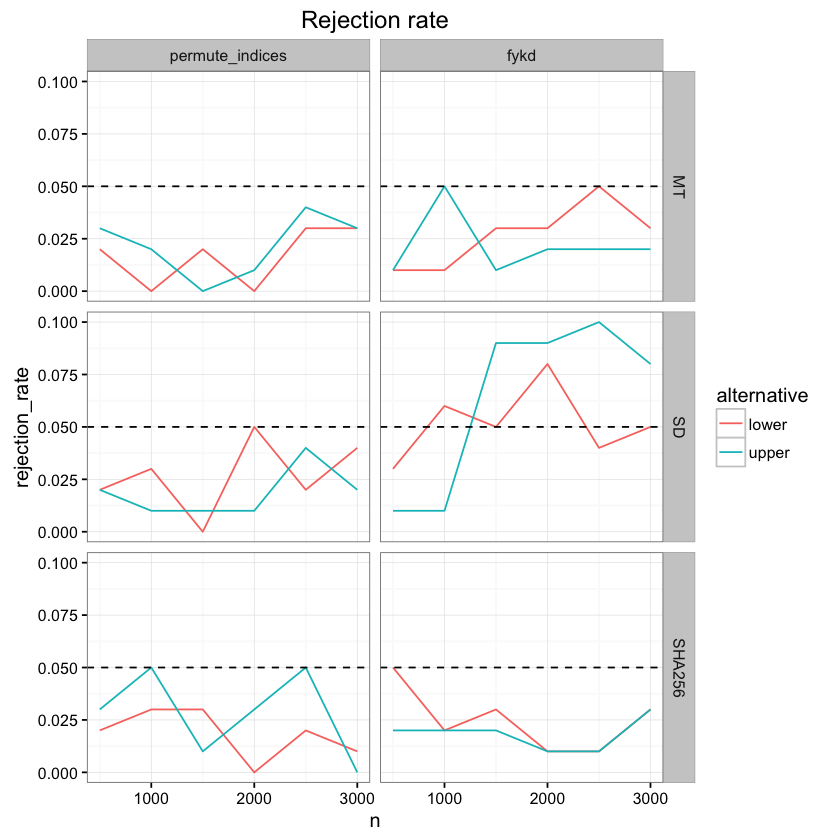

In [13]:
# plot rejection rates for varying n
res %>% 
    group_by(prng, algorithm, alternative, n) %>% 
    summarise("rejection_rate" = mean(decision == "1")) %>%
    ggplot(aes(x = n, y = rejection_rate, color = alternative)) + 
    geom_line() + 
    facet_grid(prng~algorithm) +
    geom_hline(yintercept = 0.05, linetype = "dashed") + 
    ggtitle("Rejection rate") +
    theme_bw()



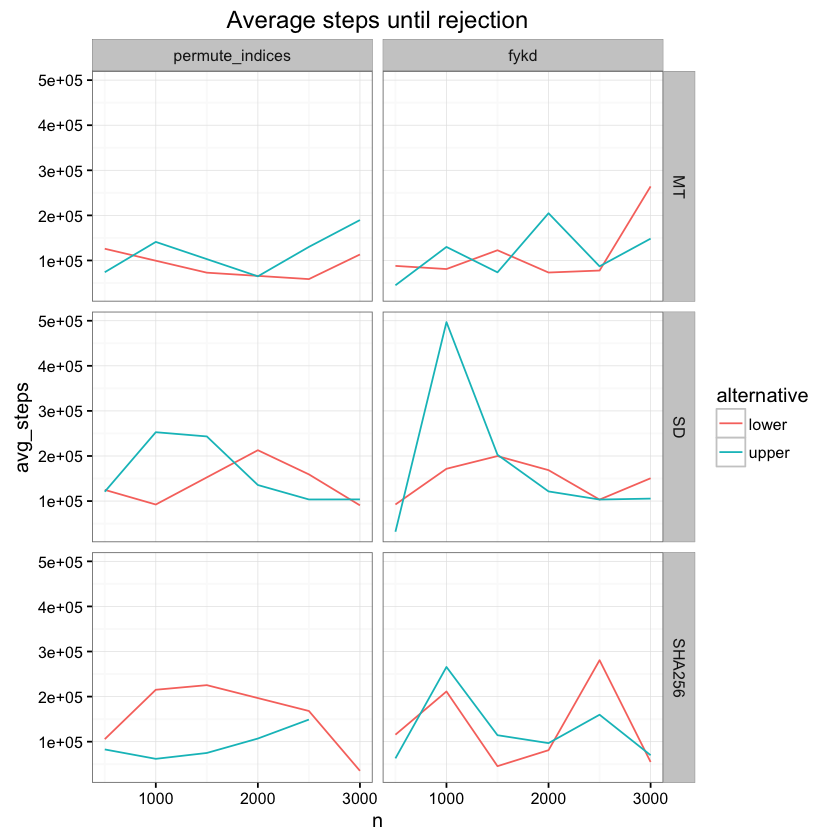

In [19]:
# plot steps for varying n
res %>% 
    filter(decision == "1") %>%
    group_by(prng, algorithm, alternative, n) %>% 
    summarise("avg_steps" = mean(as.numeric(steps))) %>%
    ggplot(aes(x = n, y = avg_steps, color = alternative)) + 
    geom_line() + 
    facet_grid(prng~algorithm) +
    ggtitle("Average steps until rejection") +
    theme_bw()


